In [1]:
import numpy as np
import pandas as pd
import cooler
import cooltools
import pybedtools

In [2]:
# Load the BED file
enhancer_bed_file ="/lustre/home/acct-medlqian/medlqian-loop3/database/enhancer/OR_63_enhancers.bed"
enhancer_bed = pybedtools.BedTool(enhancer_bed_file)
# print(enhancer_bed)

In [3]:
enhancer_unique_mapping_50kb = pd.read_csv('../files_v1/enhancer_unique_mapping_50kb.csv')

In [4]:
print(enhancer_unique_mapping_50kb)

    enhancer_idx enhancer_chrom  enhancer_start  enhancer_end  \
0              0           chr1        92545930      92546383   
1              1           chr1       173190529     173190944   
2              2           chr1       173212162     173212558   
3              3           chr1       173265692     173266108   
4              4           chr1       174035928     174036370   
5              5           chr1       174342508     174342880   
6              6          chr10        78617938      78618355   
7              7          chr10       128978758     128979150   
8              8          chr10       130098477     130098928   
9              9          chr11        49575369      49575772   
10            10          chr11        50999121      50999596   
11            11          chr11        58739096      58739523   
12            12          chr11        58810711      58811177   
13            13          chr11        59575822      59576267   
14            14         

In [106]:
# 加载Hi-C数据
Het_clr = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Het/Het.valid_pairs.5000.zoomify.mcool::resolutions/50000")
Het_clr_mat = Het_clr.matrix(sparse=True)[:]
row, col, count = Het_clr_mat.row, Het_clr_mat.col, Het_clr_mat.data

# 将稀疏矩阵转为 DataFrame
Het_pairs_df = pd.DataFrame({
    "bin1_id": row,
    "bin2_id": col,
    "count": count
})

# 删除 enhancer-related 中 bin1 == bin2 的 self-loop 行
Het_exclude_bin_self_pairs_df = Het_pairs_df[Het_pairs_df["bin1_id"] != Het_pairs_df["bin2_id"]]


In [107]:
# enhancer bin id 列表
enhancer_bin_ids = enhancer_unique_mapping_50kb["bin_idx"].tolist()
enhancer_bin_set = set(enhancer_bin_ids)  # 转换为set提高查找速度

# 所有 bin 的信息表
bin_info = Het_clr.bins()[:].reset_index().rename(columns={"index": "bin_id"})

# 添加坐标信息
Het_exclude_bin_self_pairs_df = Het_exclude_bin_self_pairs_df.merge(bin_info[["bin_id", "chrom", "start"]], left_on="bin1_id", right_on="bin_id", suffixes=("", "_1"))
Het_exclude_bin_self_pairs_df = Het_exclude_bin_self_pairs_df.merge(bin_info[["bin_id", "chrom", "start"]], left_on="bin2_id", right_on="bin_id", suffixes=("", "_2"))

# 预先过滤相关行，减少后续计算量
enhancer_related_mask = (Het_exclude_bin_self_pairs_df["bin1_id"].isin(enhancer_bin_set)) | (Het_exclude_bin_self_pairs_df["bin2_id"].isin(enhancer_bin_set))
enhancer_related_pairs = Het_exclude_bin_self_pairs_df[enhancer_related_mask].copy()

# 使用向量化操作计算 total contact
bin1_mask = enhancer_related_pairs["bin1_id"].isin(enhancer_bin_set)
bin2_mask = enhancer_related_pairs["bin2_id"].isin(enhancer_bin_set)

# 计算每个bin作为bin1时的contact
bin1_contacts = enhancer_related_pairs[bin1_mask].groupby("bin1_id")["count"].sum()

# 计算每个bin作为bin2时的contact（排除自我互作避免重复计算）
bin2_data = enhancer_related_pairs[bin2_mask & (enhancer_related_pairs["bin1_id"] != enhancer_related_pairs["bin2_id"])]
bin2_contacts = bin2_data.groupby("bin2_id")["count"].sum()

# 合并结果
all_bin_ids = set(bin1_contacts.index) | set(bin2_contacts.index)
bin_total_contact = {}
for bid in all_bin_ids:
    total = 0
    if bid in bin1_contacts.index:
        total += bin1_contacts[bid]
    if bid in bin2_contacts.index:
        total += bin2_contacts[bid]
    bin_total_contact[bid] = total

Het_bin_total_df = pd.DataFrame([
    {"bin_id": bid, "total_contact": total}
    for bid, total in bin_total_contact.items()
])


In [108]:
# enhancer bin 集合（提高判断速度）
enhancer_set = set(enhancer_bin_ids)

# enhancer–enhancer pairs
Het_ee_df = Het_exclude_bin_self_pairs_df[
    Het_exclude_bin_self_pairs_df["bin1_id"].isin(enhancer_set) & 
    Het_exclude_bin_self_pairs_df["bin2_id"].isin(enhancer_set)
].copy()

# 类型判断（向量化）
same_chrom = Het_ee_df["chrom"] == Het_ee_df["chrom_2"]
distance = abs(Het_ee_df["start"] - Het_ee_df["start_2"])
Het_ee_df["type"] = np.where(~same_chrom, "trans",
                  np.where(distance < 5_000_000, "cis_short", "cis_long"))

# 为每个 enhancer 记录它参与的 contact（注意：bin1 和 bin2 都是 enhancer）
records = []

for direction in ["bin1_id", "bin2_id"]:
    temp = Het_ee_df[["count", direction, "type"]].copy()
    temp = temp.rename(columns={direction: "bin_id"})
    records.append(temp)

all_records = pd.concat(records)

# 分组统计每个 enhancer 的 contact 分类计数
Het_enhancer_type_summary = all_records.groupby(["bin_id", "type"])["count"].sum().unstack(fill_value=0).reset_index()


In [109]:
print(Het_enhancer_type_summary)

type  bin_id  cis_long  cis_short     trans
0       1850  0.005050   0.000000  0.081825
1       3463  0.000762   0.217288  0.026695
2       3464  0.001752   0.265644  0.034647
3       3465  0.000668   0.209724  0.026520
4       3480  0.001526   0.112381  0.038390
5       3486  0.000342   0.079755  0.013584
6       4652  0.011663   0.000000  0.070415
7       5718  0.000000   0.000000  0.000000
8       6144  0.003397   0.177952  0.027216
9       6145  0.006885   0.183122  0.043348
10      6154  0.001380   0.029865  0.009562
11      9502  0.000934   0.000000  0.012314
12      9690  0.000934   0.000000  0.002577
13     11628  0.001381   0.056403  0.005540
14     11630  0.002156   0.056403  0.005070
15     11926  0.002532   0.034808  0.006488
16     11929  0.010419   0.034808  0.031072
17     13126  0.002436   0.142278  0.053418
18     13127  0.005469   0.266507  0.076504
19     13128  0.005062   0.213874  0.067031
20     17773  0.000264   0.019908  0.017703
21     17779  0.006509   0.01990

In [110]:
Het_merged_df = pd.merge(Het_bin_total_df, Het_enhancer_type_summary, on="bin_id", how="outer").fillna(0)


In [111]:
# 避免除以 0，用 np.where 或直接除后填充 NaN
Het_merged_df["cis_short_pct"] = Het_merged_df["cis_short"] / Het_merged_df["total_contact"]
Het_merged_df["cis_long_pct"]  = Het_merged_df["cis_long"]  / Het_merged_df["total_contact"]
Het_merged_df["trans_pct"]     = Het_merged_df["trans"]     / Het_merged_df["total_contact"]

# 将 total_contact = 0 的行中产生的 NaN 填为 0
Het_merged_df.fillna(0, inplace=True)

# === 排序 Het_merged_df ===
Het_merged_df_sorted = Het_merged_df.sort_values(by="cis_short_pct", ascending=False).reset_index(drop=True)


In [112]:
print(Het_merged_df)

    bin_id  total_contact  cis_long  cis_short     trans  cis_short_pct  \
0     1850       2.313699  0.005050   0.000000  0.081825       0.000000   
1     3463       2.230903  0.000762   0.217288  0.026695       0.097399   
2     3464       2.227136  0.001752   0.265644  0.034647       0.119276   
3     3465       2.193782  0.000668   0.209724  0.026520       0.095599   
4     3480       2.265170  0.001526   0.112381  0.038390       0.049612   
5     3486       2.119241  0.000342   0.079755  0.013584       0.037634   
6     4652       2.233728  0.011663   0.000000  0.070415       0.000000   
7     5718       0.000000  0.000000   0.000000  0.000000       0.000000   
8     6144       2.275709  0.003397   0.177952  0.027216       0.078196   
9     6145       2.301589  0.006885   0.183122  0.043348       0.079563   
10    6154       2.293476  0.001380   0.029865  0.009562       0.013022   
11    9502       2.246422  0.000934   0.000000  0.012314       0.000000   
12    9690       2.246831

In [114]:
# 加载Hi-C数据
Homo_clr = cooler.Cooler("/lustre/home/acct-medlqian/medlqian-loop3/data/Hi_C/20250520_Trim66_HiC_20250609_46G/merged_valid_pairs_cooler_cooltools_output/Homo/Homo.valid_pairs.5000.zoomify.mcool::resolutions/50000")
Homo_clr_mat = Homo_clr.matrix(sparse=True)[:]
row, col, count = Homo_clr_mat.row, Homo_clr_mat.col, Homo_clr_mat.data

# 将稀疏矩阵转为 DataFrame
Homo_pairs_df = pd.DataFrame({
    "bin1_id": row,
    "bin2_id": col,
    "count": count
})

# 删除 enhancer-related 中 bin1 == bin2 的 self-loop 行
Homo_exclude_bin_self_pairs_df = Homo_pairs_df[Homo_pairs_df["bin1_id"] != Homo_pairs_df["bin2_id"]]


In [115]:
# enhancer bin id 列表
enhancer_bin_ids = enhancer_unique_mapping_50kb["bin_idx"].tolist()
enhancer_bin_set = set(enhancer_bin_ids)  # 转换为set提高查找速度

# 所有 bin 的信息表
bin_info = Homo_clr.bins()[:].reset_index().rename(columns={"index": "bin_id"})

# 添加坐标信息
Homo_exclude_bin_self_pairs_df = Homo_exclude_bin_self_pairs_df.merge(bin_info[["bin_id", "chrom", "start"]], left_on="bin1_id", right_on="bin_id", suffixes=("", "_1"))
Homo_exclude_bin_self_pairs_df = Homo_exclude_bin_self_pairs_df.merge(bin_info[["bin_id", "chrom", "start"]], left_on="bin2_id", right_on="bin_id", suffixes=("", "_2"))

# 预先过滤相关行，减少后续计算量
enhancer_related_mask = (Homo_exclude_bin_self_pairs_df["bin1_id"].isin(enhancer_bin_set)) | (Homo_exclude_bin_self_pairs_df["bin2_id"].isin(enhancer_bin_set))
enhancer_related_pairs = Homo_exclude_bin_self_pairs_df[enhancer_related_mask].copy()

# 使用向量化操作计算 total contact
bin1_mask = enhancer_related_pairs["bin1_id"].isin(enhancer_bin_set)
bin2_mask = enhancer_related_pairs["bin2_id"].isin(enhancer_bin_set)

# 计算每个bin作为bin1时的contact
bin1_contacts = enhancer_related_pairs[bin1_mask].groupby("bin1_id")["count"].sum()

# 计算每个bin作为bin2时的contact（排除自我互作避免重复计算）
bin2_data = enhancer_related_pairs[bin2_mask & (enhancer_related_pairs["bin1_id"] != enhancer_related_pairs["bin2_id"])]
bin2_contacts = bin2_data.groupby("bin2_id")["count"].sum()

# 合并结果
all_bin_ids = set(bin1_contacts.index) | set(bin2_contacts.index)
bin_total_contact = {}
for bid in all_bin_ids:
    total = 0
    if bid in bin1_contacts.index:
        total += bin1_contacts[bid]
    if bid in bin2_contacts.index:
        total += bin2_contacts[bid]
    bin_total_contact[bid] = total

Homo_bin_total_df = pd.DataFrame([
    {"bin_id": bid, "total_contact": total}
    for bid, total in bin_total_contact.items()
])


In [116]:
# enhancer bin 集合（提高判断速度）
enhancer_set = set(enhancer_bin_ids)

# enhancer–enhancer pairs
Homo_ee_df = Homo_exclude_bin_self_pairs_df[
    Homo_exclude_bin_self_pairs_df["bin1_id"].isin(enhancer_set) & 
    Homo_exclude_bin_self_pairs_df["bin2_id"].isin(enhancer_set)
].copy()

# 类型判断（向量化）
same_chrom = Homo_ee_df["chrom"] == Homo_ee_df["chrom_2"]
distance = abs(Homo_ee_df["start"] - Homo_ee_df["start_2"])
Homo_ee_df["type"] = np.where(~same_chrom, "trans",
                  np.where(distance < 5_000_000, "cis_short", "cis_long"))

# 为每个 enhancer 记录它参与的 contact（注意：bin1 和 bin2 都是 enhancer）
records = []

for direction in ["bin1_id", "bin2_id"]:
    temp = Homo_ee_df[["count", direction, "type"]].copy()
    temp = temp.rename(columns={direction: "bin_id"})
    records.append(temp)

all_records = pd.concat(records)

# 分组统计每个 enhancer 的 contact 分类计数
Homo_enhancer_type_summary = all_records.groupby(["bin_id", "type"])["count"].sum().unstack(fill_value=0).reset_index()


In [117]:
Homo_merged_df = pd.merge(Homo_bin_total_df, Homo_enhancer_type_summary, on="bin_id", how="outer").fillna(0)
# 避免除以 0，用 np.where 或直接除后填充 NaN
Homo_merged_df["cis_short_pct"] = Homo_merged_df["cis_short"] / Homo_merged_df["total_contact"]
Homo_merged_df["cis_long_pct"]  = Homo_merged_df["cis_long"]  / Homo_merged_df["total_contact"]
Homo_merged_df["trans_pct"]     = Homo_merged_df["trans"]     / Homo_merged_df["total_contact"]

# 将 total_contact = 0 的行中产生的 NaN 填为 0
Homo_merged_df.fillna(0, inplace=True)


In [118]:
print(Homo_merged_df)

    bin_id  total_contact  cis_long  cis_short     trans  cis_short_pct  \
0     1850       2.301030  0.001593   0.000000  0.003016       0.000000   
1     3463       2.322046  0.000407   0.251932  0.006790       0.108496   
2     3464       2.279027  0.000000   0.299932  0.004398       0.131605   
3     3465       2.250294  0.000685   0.221620  0.002316       0.098485   
4     3480       2.321308  0.000501   0.068673  0.007927       0.029584   
5     3486       2.138432  0.000000   0.065186  0.003004       0.030483   
6     4652       2.223878  0.004943   0.000000  0.010117       0.000000   
7     5718       0.000000  0.000000   0.000000  0.000000       0.000000   
8     6144       2.285865  0.001702   0.184305  0.004820       0.080628   
9     6145       2.291919  0.002309   0.188742  0.006116       0.082351   
10    6154       2.258008  0.000933   0.039765  0.003132       0.017611   
11    9502       2.212447  0.000000   0.000000  0.002553       0.000000   
12    9690       2.203426

In [119]:
combined_df = pd.merge(
    Het_merged_df, 
    Homo_merged_df, 
    on="bin_id", 
    how="outer",  # 如果你希望保留所有 enhancer bin，可用 outer；否则用 inner
    suffixes=("_Het", "_Homo")
)

# === 排序 Het_merged_df ===
combined_df = combined_df.sort_values(by="cis_short_pct_Het", ascending=False).reset_index(drop=True)


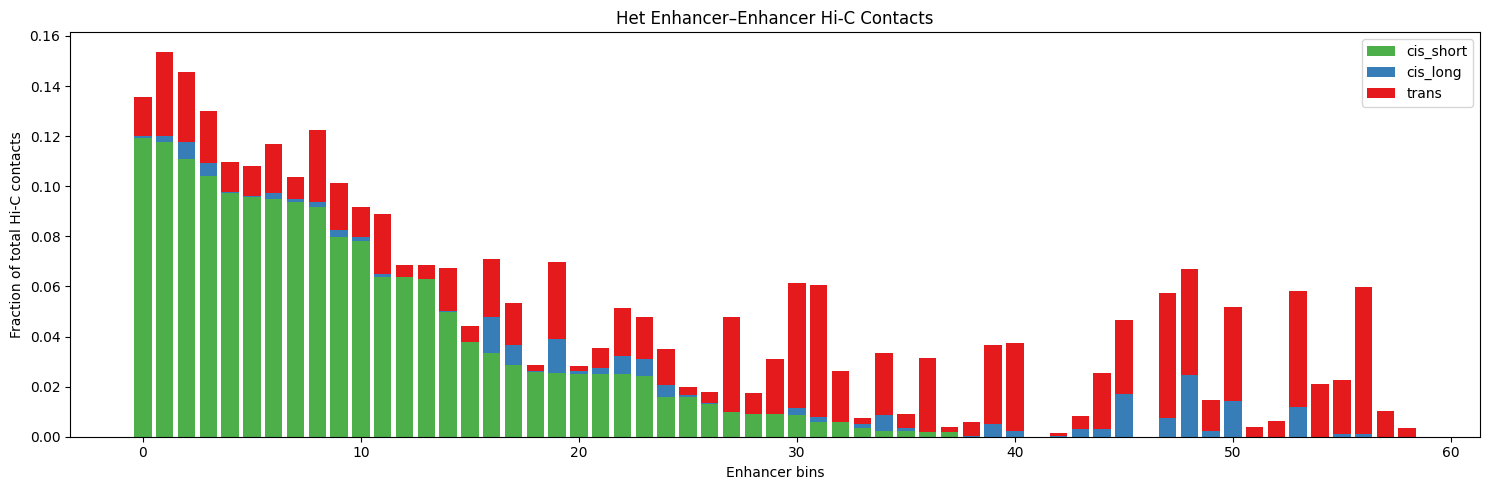

In [113]:
import matplotlib.pyplot as plt
import numpy as np


# 图像大小
plt.figure(figsize=(15, 5))

# 初始化底部为 0
bottom = np.zeros(len(Het_merged_df_sorted))

# 设置颜色
colors = {
    "cis_short_pct": "#4daf4a",
    "cis_long_pct": "#377eb8",
    "trans_pct": "#e41a1c"
}

# 绘制堆叠条形图
for col in ["cis_short_pct", "cis_long_pct", "trans_pct"]:
    plt.bar(
        Het_merged_df_sorted.index, 
        Het_merged_df_sorted[col], 
        bottom=bottom, 
        label=col.replace("_pct", ""), 
        color=colors[col]
    )
    bottom += Het_merged_df_sorted[col]

# 坐标轴与图例
plt.xlabel("Enhancer bins")
plt.ylabel("Fraction of total Hi-C contacts")
plt.title("Het Enhancer–Enhancer Hi-C Contacts")
plt.legend()
plt.tight_layout()
plt.show()


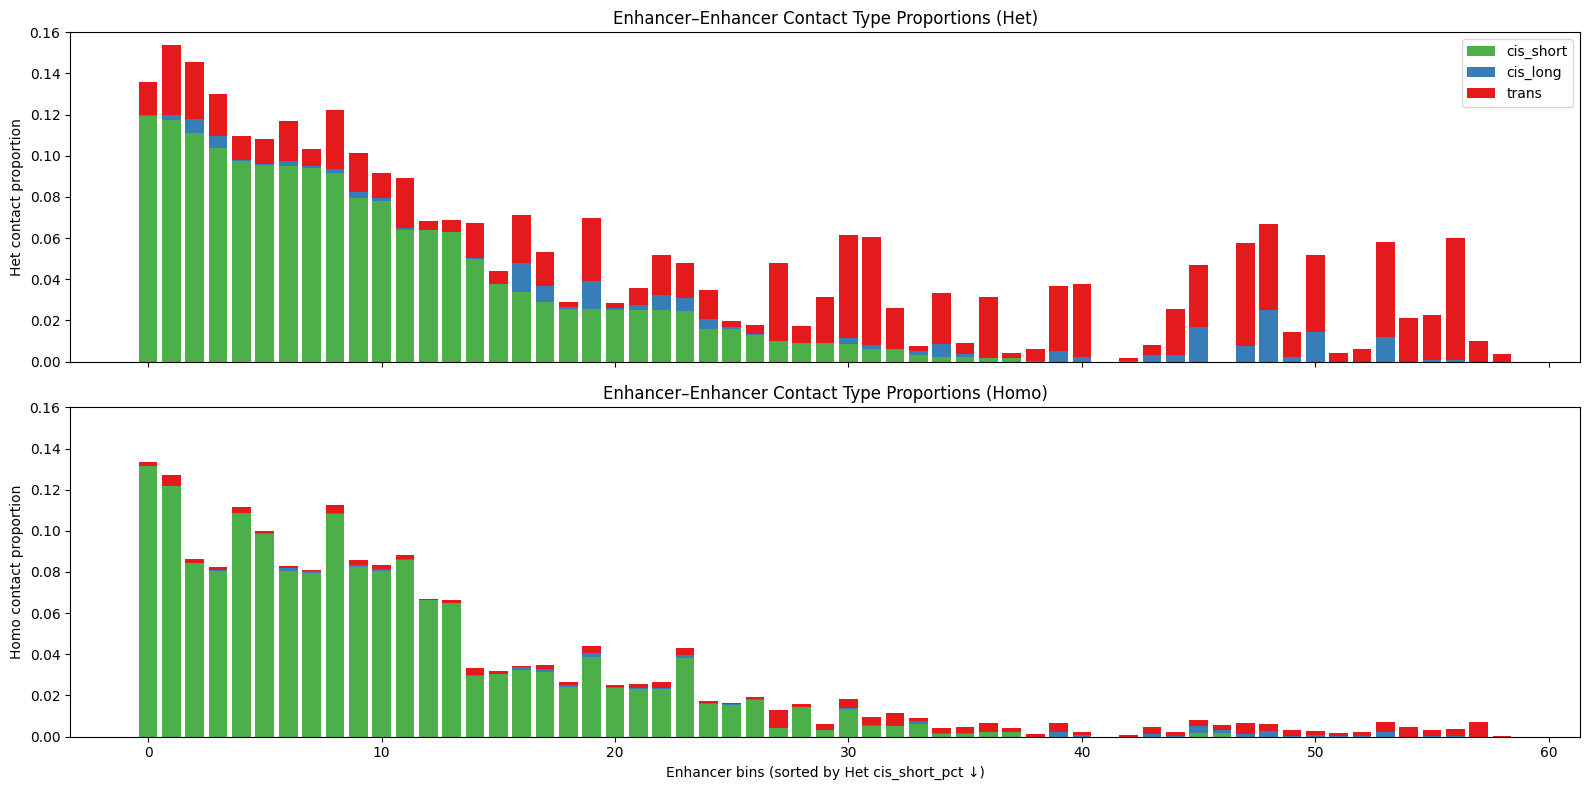

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# 按 Het 的 cis_short_pct 排序
sorted_df = combined_df.sort_values(by="cis_short_pct_Het", ascending=False).reset_index(drop=True)

# 设置颜色
colors = {
    "cis_short": "#4daf4a",
    "cis_long": "#377eb8",
    "trans": "#e41a1c"
}

fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# ====== 上图：Het ======
bottom = np.zeros(len(sorted_df))
for col in ["cis_short", "cis_long", "trans"]:
    axs[0].bar(
        sorted_df.index, 
        sorted_df[f"{col}_pct_Het"], 
        bottom=bottom, 
        color=colors[col], 
        label=col
    )
    bottom += sorted_df[f"{col}_pct_Het"]

axs[0].set_ylabel("Het contact proportion")
axs[0].set_title("Enhancer–Enhancer Contact Type Proportions (Het)")
axs[0].set_ylim(0, 0.16)  # 设置 y 轴范围
axs[0].legend()

# ====== 下图：Homo ======
bottom = np.zeros(len(sorted_df))
for col in ["cis_short", "cis_long", "trans"]:
    axs[1].bar(
        sorted_df.index, 
        sorted_df[f"{col}_pct_Homo"], 
        bottom=bottom, 
        color=colors[col]
    )
    bottom += sorted_df[f"{col}_pct_Homo"]

axs[1].set_ylabel("Homo contact proportion")
axs[1].set_title("Enhancer–Enhancer Contact Type Proportions (Homo)")
axs[1].set_xlabel("Enhancer bins (sorted by Het cis_short_pct ↓)")
axs[1].set_ylim(0, 0.16)  # 设置 y 轴范围

plt.tight_layout()
plt.savefig("../plots_v1/enhancer_contact_comparison_stacked_bar.pdf", dpi=300)
plt.show()


In [124]:
from scipy.stats import wilcoxon

results = {}

for contact_type in ["cis_short", "cis_long", "trans"]:
    het_col = f"{contact_type}_pct_Het"
    homo_col = f"{contact_type}_pct_Homo"
    
    # 取出两个样本（配对）
    het_values = combined_df[het_col]
    homo_values = combined_df[homo_col]
    
    # 过滤缺失或全0情况（可选）
    mask = (~het_values.isna()) & (~homo_values.isna())
    het_values = het_values[mask]
    homo_values = homo_values[mask]
    
    # Wilcoxon signed-rank test，two-sided
    stat, pval = wilcoxon(het_values, homo_values, alternative='two-sided')
    
    results[contact_type] = {"statistic": stat, "p_value": pval}

# 打印结果
for k, v in results.items():
    print(f"{k}: statistic={v['statistic']:.4f}, p-value={v['p_value']:.4g}")


cis_short: statistic=357.0000, p-value=0.4762
cis_long: statistic=58.0000, p-value=3.472e-08
trans: statistic=8.0000, p-value=5.322e-11


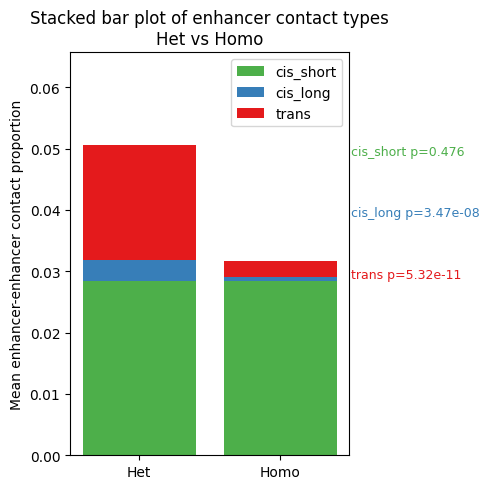

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

contact_types = ["cis_short", "cis_long", "trans"]
colors = {
    "cis_short": "#4daf4a",
    "cis_long": "#377eb8",
    "trans": "#e41a1c"
}

# 计算均值和p值（略，使用已有代码）

x = np.array([0, 1])
width = 0.8

fig, ax = plt.subplots(figsize=(5,5))

bottom_het = 0
bottom_homo = 0

for i, ctype in enumerate(contact_types):
    ax.bar(x[0], means_het[i], width, bottom=bottom_het, color=colors[ctype], label=ctype if x[0] == 0 else "")
    ax.bar(x[1], means_homo[i], width, bottom=bottom_homo, color=colors[ctype])
    bottom_het += means_het[i]
    bottom_homo += means_homo[i]

ax.set_xticks(x)
ax.set_xticklabels(["Het", "Homo"])
ax.set_ylabel("Mean enhancer-enhancer contact proportion")
ax.set_title("Stacked bar plot of enhancer contact types\nHet vs Homo")
ax.set_ylim(0, max(bottom_het, bottom_homo)*1.3)

# 画完主图后，获取柱子最大高度
max_height = max(bottom_het, bottom_homo)

# x轴两柱位置分别是0和1，放p值文本在x=1.2（图右侧）
x_text = 1.5
y_start = max_height  # 从柱子顶端开始
y_step = 0.01         # 每条p值竖直间距

for i, p in enumerate(p_values):
    ax.text(x_text, y_start - i * y_step, f"{contact_types[i]} p={p:.3g}",
            ha='left', va='top', fontsize=9, color=colors[contact_types[i]])

ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig("../plots_v1/enhancer_contact_comparison_stacked_mean_barplot_with_stat.pdf")
plt.show()


In [149]:
for i, ctype in enumerate(contact_types):
    print(f"{ctype} mean Het: {means_het[i]:.4f}, mean Homo: {means_homo[i]:.4f}")


cis_short mean Het: 0.0284, mean Homo: 0.0285
cis_long mean Het: 0.0033, mean Homo: 0.0007
trans mean Het: 0.0188, mean Homo: 0.0026


In [150]:
print("均值结果：")
for i, ctype in enumerate(contact_types):
    print(f"{ctype} mean Het: {means_het[i]:.4f}, mean Homo: {means_homo[i]:.4f}")


均值结果：
cis_short mean Het: 0.0284, mean Homo: 0.0285
cis_long mean Het: 0.0033, mean Homo: 0.0007
trans mean Het: 0.0188, mean Homo: 0.0026
